<a href="https://colab.research.google.com/github/TejodhayBonam/Data-Science-Projects/blob/main/Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyopencl==2020.1
! pip install pycuda

  Using cached pycuda-2021.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached Mako-1.1.6-py2.py3-none-any.whl (75 kB)
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627229 sha256=d19863e7a013888a440c844439265d7fba9e014dd5ff808c73f0c76460a3df6d
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
Successfully built pycuda


In [ ]:
!rm -rf data/ && mkdir data
!cd data && git clone https://github.com/pypr/compyle.git
!cd data/compyle && python setup.py install

Cloning into 'compyle'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 2278 (delta 183), reused 180 (delta 95), pack-reused 1977
Receiving objects: 100% (2278/2278), 575.07 KiB | 12.78 MiB/s, done.
Resolving deltas: 100% (1324/1324), done.
Compiling compyle/thrust/sort.pyx because it changed.
[1/1] Cythonizing compyle/thrust/sort.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/compyle/compyle/thrust/sort.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:484: UserWarning: Normalizing '0.9.dev' to '0.9.dev0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
creating compyle.egg-info
writing compyle.egg-info/PKG-INFO
w

In [ ]:
import numpy as np
import pandas as pd

Get the data:

In [ ]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('https://raw.githubusercontent.com/krishnaik06/Movie-Recommender-in-python/master/u.data', sep='\t', names = column_names)

In [ ]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:


In [ ]:
movie_titles = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/Movie-Recommender-in-python/master/Movie_Id_Titles")

In [ ]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [ ]:
df = pd.merge(df, movie_titles,on='item_id')

In [ ]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


#EDA

Let's explore the data a bit and get a look at some of the best rated movies:

##Visualization Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [ ]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [ ]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [ ]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now set the number of ratings column:

In [ ]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few histograms:

In [ ]:
import matplotlib.pyplot as plt

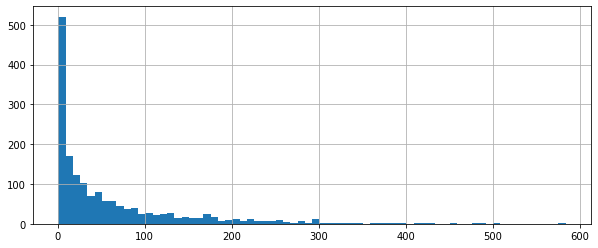

In [ ]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

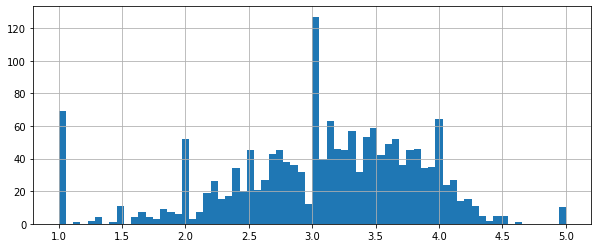

In [ ]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

In [ ]:
import seaborn as sns
sns.set_style('white')

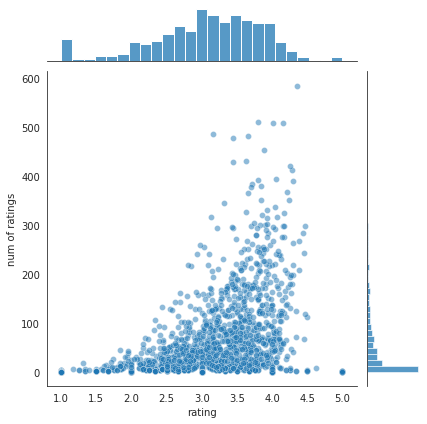

In [ ]:
sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha = 0.5)

Okay! Now that we have a general idea of how the data looks like, lets' move on to creating a simple recommendation system:

#**Recommending similar movies**

Now let's create a matrix that has the user ids on one axis and the  movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note, there will be a lot of NaN values, because most people have not seen most of the movies 

In [ ]:
moviemat = df.pivot_table(index = 'user_id', columns ='title', values ='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movie:

In [ ]:
ratings.sort_values('num of ratings', ascending =False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Let's choose two movies: Starwars, a sci-fi movie; and Liar Lair, a comedy.

In [ ]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's grab the user ratings for those two movies:

In [ ]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can then use corrwith() method to get correlations between two pandas series: 

In [ ]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [ ]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that really make sense. This is because there are a lot of movies only watched once by users who watched starwars(it was the most popular movie)

In [ ]:
corr_starwars.sort_values('Correlation', ascending =False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews(this value was chosen based off the histogram from earlier)

In [ ]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now sort the values and notice how the titles make a lot more sense:

In [ ]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation', ascending = False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now the same for the comedy Liar Liar:

In [ ]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns = ['Correlation'])
corr_liarliar.dropna(inplace = True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation', ascending =False).head()


,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


**Done!**